In [1]:
# You should only need these 3 imports to complete this assignment
import pandas as pd
import numpy as np
from plotnine import *


# 0. Together

## Entropy

Entropy is a measure of disorder/chaos. We want ordered and organized data in the leaf nodes of our decision trees. So we want LOW entropy. **Entropy** is defined as:

$$ E = -\sum_1^N p_i* log_2(p_i) $$

Where $N$ is the number of categories or labels in our outcome variable.

This is compared to **gini impurity** which is:

$$GI = 1 - \sum_1^N p_i^2$$

Gini impurity is probability of misclassifying a random data point from that node.


(if you're super into decision trees, check out this paper [Theoretical comparison between the Gini Index and
Information Gain criteria](https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf))

### *Question*

WHY do we want the leaf nodes of our tree to be ordered (have low entropy or impurity?)?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />


## Measures of Chaos for a Split

When you split a node, we now have two new nodes. In order to calculate the chaos (entropy or gini impurity) of the split, we have to calculate the chaos (entropy or gini impurity) for EACH of the new nodes and then calculate the weighted average chaos (entropy or gini impurity).  

The reason we weight each node differently in this calculation, is because if a node has more data in it, than it has more impact, and therefore its measure of chaos (entropy or gini impurity) should count more.

In general, once you've calculated the chaos (entropy or gini impurity) for each of the new nodes, you'll use this formula to calculate the weighted average:


$$ WC = (\frac{N_L}{Total}* C_L) + (\frac{N_R}{Total}* C_R)$$

Where $N_L$ is the number of data points in the Left Node, $N_R$ is the number of data points in the Right Node, and $Total$ is the total number of data points in that split. $C_R$ and $C_L$ are the chaos measure (entropy of gini impurity) for the right and left nodes, respectively.



## Building a Decision Tree

In [2]:
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, LabelEncoder #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

d = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")

predictors = ["Pregnancies","Glucose","BloodPressure","SkinThickness",
              "Insulin","BMI","DiabetesPedigreeFunction","Age"]
X = d[predictors]
y = d["Outcome"]

# TTS
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1234)


In [3]:
tree = DecisionTreeClassifier(random_state = 1234)
tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

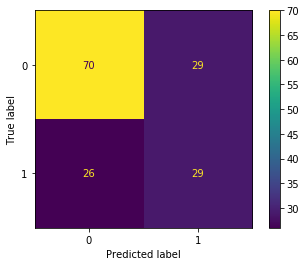

In [4]:
plot_confusion_matrix(tree, X_test, y_test)

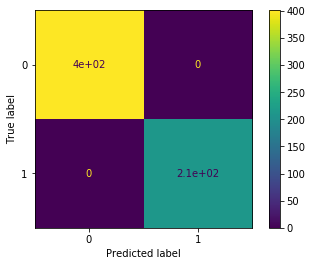

In [5]:
plot_confusion_matrix(tree, X_train, y_train)

In [6]:
# new model
tree.get_depth()

13

In [7]:
def simTree(n = 200, max_depth = "none"):
    
    n2 = int(n/2)
    
    #---generate data-----------------------------------
    # generate predictors, only x1 and x2 are related to the outcome
    x1 = np.concatenate([np.random.normal(0,1,n2),
                         np.random.normal(2,1,n2)])
    x2 = np.random.normal(0,1,n)
    x3 = np.concatenate([np.random.binomial(1,0.2,n2),
                        np.random.binomial(1,0.9, n2)])
    
    # generate outcome
    outcome = np.repeat(["A","B"], n2)
    
    # data frame
    df = pd.DataFrame({"x1": x1, "x2" : x2, "x3": x3, "out": outcome})
    
    #---set X and y------------------------------------
    X = df[["x1","x2","x3"]]
    y = df[["out"]]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

    
    #---build models------------------------------------
    
    # if there is no max depth, build regular tree
    if max_depth == "none":
        tree = DecisionTreeClassifier() 
        
    # otherwise, set max_depth
    else:
        tree = DecisionTreeClassifier(max_depth = max_depth)
        
    tree.fit(X_train,y_train)
    
    
    #---get training and test Accuracy---------------------
    train_acc = accuracy_score(y_train,tree.predict(X_train))
    test_acc = accuracy_score(y_test,tree.predict(X_test))
    
    return(pd.DataFrame({"Set": ["Train", "Test",],
                        "Depth": [str(max_depth), str(max_depth)],
                        "Acc": [train_acc,
                               test_acc]}))
    
    

In [8]:
sims = [simTree(n = 2000, max_depth = x) for x in np.repeat(range(2,10), 100)]
sims = sims + [simTree(n = 2000, max_depth = "none") for i in range(0,100)]
sims_df = pd.concat(sims)

sims_df.head()

,Set,Depth,Acc
0,Train,2,0.908750
1,Test,2,0.895000
0,Train,2,0.920625
1,Test,2,0.902500
0,Train,2,0.899375


### Plotting it!
Now that we've run our simulation, use the `sims_df` data frame to make a plot that shows us the difference between the train and test accuracy for our full (not limited) and pruned (has a max_depth) trees. 

Use `geom_boxplot()` to plot Acc for each Tree `Depth`. Fill by Set.

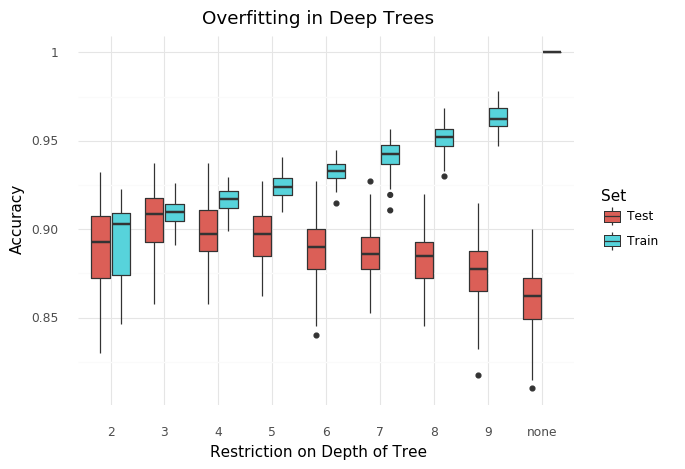

<ggplot: (8764790129327)>

In [10]:
(ggplot(sims_df, aes(x = "Depth", y = "Acc", fill = "Set")) +
geom_boxplot() + theme_minimal() + 
labs(x = "Restriction on Depth of Tree",
    y = "Accuracy",
    title = "Overfitting in Deep Trees"))

# 1. Measures of Chaos

## Gini Impurity

Use python and numpy to write two functions, as described in the comments below.

- LNP: Left Node Positive (cases)
- LNN: Left Node Negative (cases)
- RNP: Right Node Positive (cases)
- RNN: Right Node Negative (cases)
<img src = "https://drive.google.com/uc?id=1MQEeJDxxcV8zmhzBgaDZ2QY0Ng8z8hz8" width = 300px/>

In [ ]:
### YOUR CODE HERE ############


def gini():
    # this function calculates the gini impurity for ONE node (left, right, or root!)
    # this function should take in the POSITIVE cases and NEGATIVE cases as arguments
    # and calculate the gini impurity for that node based on the formula above
    # return the impurity for the node.
    
    pass

def gini_split():
    
    # this function takes FOUR arguments: LNP, LNN, RNP, and RNN and calculates
    # the gini impurity for each node (by calling gini()) and then calculates
    # the WEIGHTED average of the impurity in each node.
    # return the impurity for the split.
    
    pass

### YOUR CODE HERE ###############

In [ ]:
# use this to test your code, if it prints True, you got the right answer

abs(gini_split(10,5,2,12) - 0.3481116584564861) <= 0.0001

## Entropy

Use python and numpy to write two functions, as described by the comments below. If you want to read more about entropy, see this [article](https://bricaud.github.io/personal-blog/entropy-in-decision-trees/).

hint: `np.log2()`

In [ ]:
### YOUR CODE HERE ###############

def entropy():
    # this function calculates the entropy for ONE node (left, right, or root!)
    # this function should take in the POSITIVE cases and NEGATIVE cases counts as arguments
    # and calculate the entropy for that node based on the formula above
    pass

def entropy_split():
    # this function takes FOUR arguments: LNP, LNN, RNP, and RNN and calculates
    # the entropy for each node (by calling entropy()) and then calculates
    # the WEIGHTED average of the entropy in each node.
    # return the entropy for the split.
    pass

### YOUR CODE HERE ###############

In [ ]:
# use this to test your code, if it prints True, you got the right answer

abs(entropy_split(10,5,2,12) - 0.7606157383093077) <= 0.0001

# 2. Build a Categorical Decision Tree

This dataset from UCI is about edible (`e`) and poisonous (`p`) mushrooms.

- `gill-size`: `b` is for broad gills, `n` is for narrow gills.
- `bruises`: `t` is for true, there are bruises, `f` for false, there are no bruises.
- `poison`: `e` for edible, `p` for poison.

In [11]:
# Load Mushroom Data------------------------------------
import pandas as pd

# see this site for what variables mean: http://archive.ics.uci.edu/ml/datasets/Mushroom
mush = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data")

mush.columns = ['poison','cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size',
                'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
                'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number','ring-type',
                'spore-print-color', 'population', 'habitat']

mush.head()

,poison,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


For your sanity, let's restrict our dataset to 3 predictor variables...

In [13]:
mush_small = mush[["poison", "bruises", "gill-size"]]

In [ ]:
# make a bar plot of counts of edible/poisonous mushrooms############
(ggplot(mush_small, aes(###)) + geom_bar() + theme_minimal())

In [ ]:
# make a bar plot of counts of bruised/not-bruised mushrooms############
(ggplot(mush_small, aes(###)) + geom_bar() + theme_minimal())

In [ ]:
# make a bar plot of counts of broad/narrow gilled mushrooms############
(ggplot(mush_small, aes(###)) + geom_bar() + theme_minimal())

## 2.1 Build!

Use the functions you built earlier to build a (very small) decision tree that classifies each data point as either edible (`e`) or poisonous (`p`). You can choose to either use entropy or gini impurity. 

### Layer 1

Choose which variable to use to split the first layer. You have three options: leave the root node alone, split on gill-size, or split on bruises.



In [15]:
# create dictionaries of possible splits############
# Try getting something like this for the root node: {'e': 4208, 'p': 3915}
# where xxxx are the counts for edible and poisonous mushrooms
# BUT CALCULATE IT FROM THE DATA, DON'T JUST HARDCODE THAT DICTIONARY
# use this this as an example! But feel free to come up with more elegant ways
poison_count = {"e": mush_small.loc[mush_small.poison == "e"].shape[0],
                "p": mush_small.loc[mush_small.poison == "p"].shape[0]}

poison_count

{'e': 4208, 'p': 3915}

In [16]:
# Something like this for splitting on bruise: 
# bruise_dict = {'f': {'e': 1456, 'p': 3292}, 't': {'e': 2752, 'p': 623}}
# where bruise_dict['f']['e'] would be the # of non-bruised, edible mushrooms
# BUT CALCULATE IT FROM THE DATA, DON'T JUST HARDCODE THAT DICTIONARY

### YOUR CODE HERE ###

In [17]:
# Something like this for splitting on gill: 
# gill_dict = {'b': {'e': 5612, 'p': 1692}, 'n': {'e': 2511, 'p': 2223}}
# where gill_dict['b']['e'] would be the # of non-bruised, edible mushrooms
# BUT CALCULATE IT FROM THE DATA, DON'T JUST HARDCODE THAT DICTIONARY


### YOUR CODE HERE ###

In [18]:
# calculate impurity/entropy of each possible split using your functions###########

# 1. no split (impurity/entropy of root node)



# 2. split on bruise (impurity/entropy of bruise node)



# 3. split on gill-size (impurity/entropy of gill node)


In [19]:
# choose which split improves prediction most############

### *Question*

Does splitting the root node improve the tree? How can you tell?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

### Answer


### 2.1.2 Create Classifications

Pretend that this decision stump (a decision tree with only one layer, selected in the previous part) is your final tree. Generate the classification for each data point and store it in `mush_small`. You should end up with a column where the value is `e` if your predicted the mushroom is edible, and `p` if you predicted the model is poisonous.


Remember, once you have chosen your split, we predict that the data point in each node is whatever class is most common in that node. For example, if you did no splits, and just used the root node, we would predict that all mushrooms are edible (`e`) because it is the most common in the root node (`{'e': 4208, 'p': 3915}`).

In [1]:
# classification############

### 2.1.3 Calculate Accuracy

Count how often your model made the correct classification. How well did your model do?

Remember that accuracy is the same as checking how many times the true classification is `==` our predicted classification...

In [ ]:
# accuracy############

# 3. Chaos

### *Question*

When would Gini Impurity be 0? When would Entropy be 0? What does that mean about our tree/node?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

### Answer